# 2nd order Quality Check

This scripts looks into the data in more depths. It can handle DAS data including data gaps. If this is too complicated, assume that there are no data gaps.

In [2]:
# load modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
import scipy
import os
import pandas as pd
import DASfuncs
import importlib

importlib.reload(DASfuncs)

<module 'DASfuncs' from '/Users/graeffd/Documents/projects/2022-25_SPI_GreenFjord/analysis/scripts/GreenFjord_DAS/DASfuncs.py'>

In [3]:
# get files
t_start = datetime.datetime(2023,6,1,22,20)
t_end = datetime.datetime(2023,6,1,23,20)

files = DASfuncs.get_Onyx_h5('../../../data/lab/SaltwaterTankTest/DAS_data/', t_start, t_end)
print('{} files in directory'.format(len(files)))

55 files in directory


In [4]:
# read the data
data_rec, t_rec, attrs = DASfuncs.read_Onyx_h5(files)

In [377]:
# fill contiuous parts of data into array
time_list, data_list = DASfuncs.split_continuous_data(t_rec, data_rec, attrs)

In [378]:
# fill data gaps in array
times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, data_list, attrs, t_format='datetime')
print('Data filles {:.2} GB of memory.'.format(sys.getsizeof(data_filled)/2**30))

Data filles 1.2 GB of memory.


Text(0.5, 0, 'Time [s]')

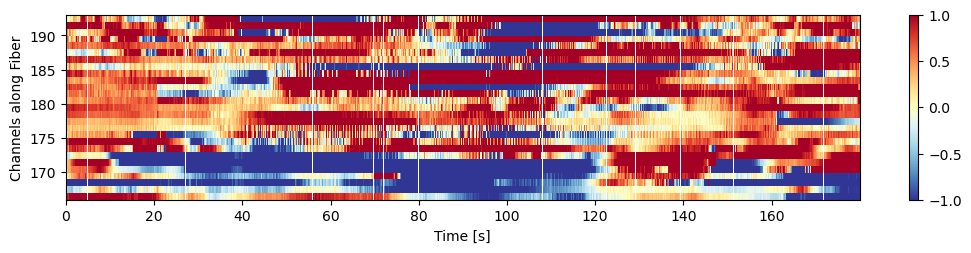

In [379]:
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))

# left plot
im = ax.imshow(data_filled.T, aspect='auto',
             origin='lower',
             vmin=-1,#np.percentile(data[~np.isnan(data)],5),
             vmax=1,#np.percentile(data[~np.isnan(data)],95),
             extent=[0,data.shape[0]/(attrs['PulseRate']), 
                  attrs['StartLocusIndex'],
                  attrs['StartLocusIndex']+data.shape[1]],
             cmap='RdYlBu_r',
             interpolation='none'
             )

cbar = plt.colorbar(im)
ax.set_ylabel('Channels along Fiber')
ax.set_xlabel('Time [s]')

## Time Series Data

In [380]:
# get data gaps
gap_list = DASfuncs.get_gaps(time_list, attrs)

Text(0.5, 0, 'Time')

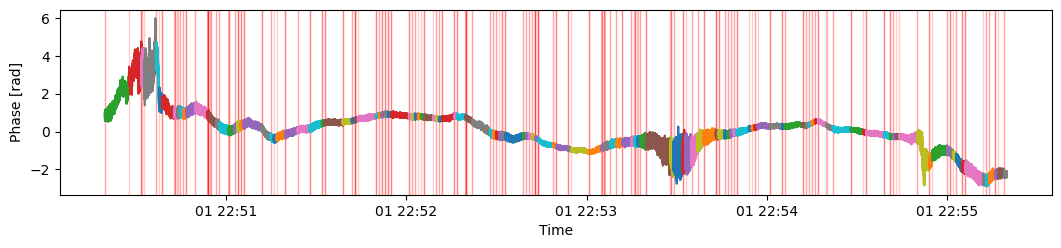

In [396]:
# plot time series with different colors indicating chunks of data
cha = 0
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))
for t, d in zip(time_list, data_list):
    # plt.plot(t,d[:,cha])
    # the convertion to datatime takes long...
    ax.plot(DASfuncs.sintela_to_datetime(t),d[:,cha]) # with datetime formatting
for gap in gap_list:
    # plt.axvspan(gap[0], gap[1], alpha=0.2, color='red')
    # the convertion to datatime takes long...
    ax.axvspan(DASfuncs.sintela_to_datetime(gap[0]), DASfuncs.sintela_to_datetime(gap[1]), alpha=0.2, color='red') # with datetime formatting
ax.set_ylabel('Phase [rad]')
ax.set_xlabel('Time')

## Filtering

In [382]:
# filtering
sos = scipy.signal.butter(2, (10,100),'bandpass', fs=attrs['PulseRate'], output='sos') # frequency in m
filt_list = [apply_sosfiltfilt_with_nan(sos, arr, axis=0) for arr in data_list]

Text(0.5, 0, 'Time')

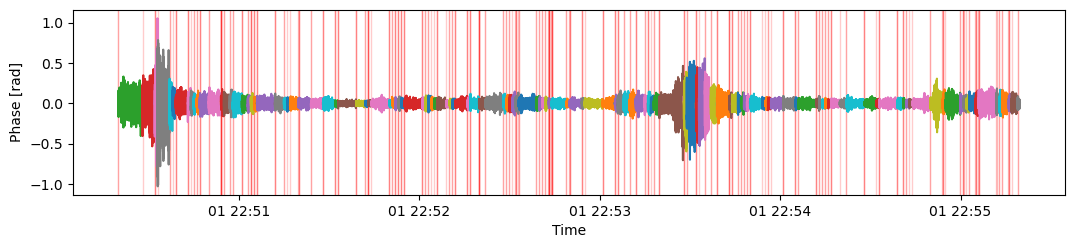

In [397]:
# plot filtered time series
cha = 0
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))
for t, d in zip(time_list, filt_list):
    # plt.plot(t,d[:,cha])
    # the convertion to datatime takes long...
    ax.plot(DASfuncs.sintela_to_datetime(t),d[:,cha]) # with datetime formatting
for gap in gap_list:
    # plt.axvspan(gap[0], gap[1], alpha=0.2, color='red')
    # the convertion to datatime takes long...
    ax.axvspan(DASfuncs.sintela_to_datetime(gap[0]), DASfuncs.sintela_to_datetime(gap[1]), alpha=0.2, color='red') # with datetime formatting
ax.set_ylabel('Phase [rad]')
ax.set_xlabel('Time')

In [384]:
# fill filtered data into array
_, data_filt = DASfuncs.fill_data_gaps(time_list, filt_list, attrs, t_format='datetime')

Text(0.5, 0, 'Time [s]')

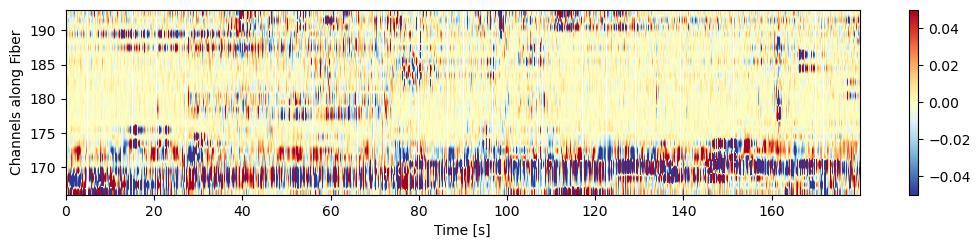

In [395]:
# plot filtered waterfall plot
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))

# left plot
im = ax.imshow(data_filt.T, aspect='auto',
             origin='lower',
             vmin=-0.05,#np.percentile(data[~np.isnan(data)],10),
             vmax=0.05,#np.percentile(data[~np.isnan(data)],90),
             extent=[0,data.shape[0]/(attrs['PulseRate']), 
                  attrs['StartLocusIndex'],
                  attrs['StartLocusIndex']+data.shape[1]],
             cmap='RdYlBu_r',
             # interpolation='none'
             )

cbar = plt.colorbar(im)
ax.set_ylabel('Channels along Fiber')
ax.set_xlabel('Time [s]')

In [6]:
# filter data -> do everything normal, but loop over chunks of the array (make it fast)

# fk-analysis

Steps for all kinds of data manipulaiton: 
1) slice data into continuous segments
2) do data manipulation on these
3) concatenate data

In [5]:
downsamplefactor=10


data_detrend = scipy.signal.detrend(data_rec)
downsampled_detrend_data = data_detrend[::downsamplefactor,:]

ft = np.fft.fftshift(np.fft.fft2(downsampled_detrend_data))
# f = np.fft.fftshift(np.fft.fftfreq(downsampled_detrend_data.shape[0], d=0.01 * downsamplefactor))
# k = np.fft.fftshift(np.fft.fftfreq(downsampled_detrend_data.shape[1], d=attrs['SpatialSamplingInterval']))

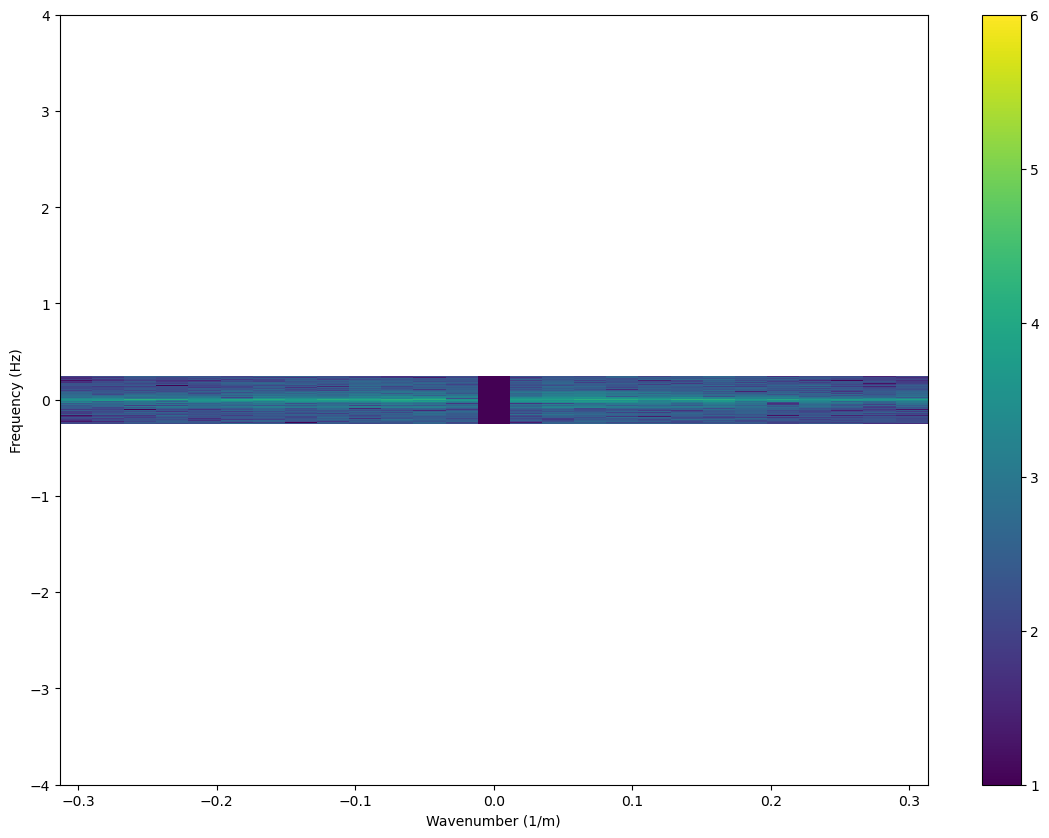

In [416]:
plt.subplots(figsize=(14,10))
c=plt.pcolormesh(k,f,np.log10(np.abs(ft)),vmin=1,vmax = 6)
plt.colorbar(c)
plt.xlabel('Wavenumber (1/m)')
plt.ylabel('Frequency (Hz)')
plt.ylim([-4,4])
plt.show()

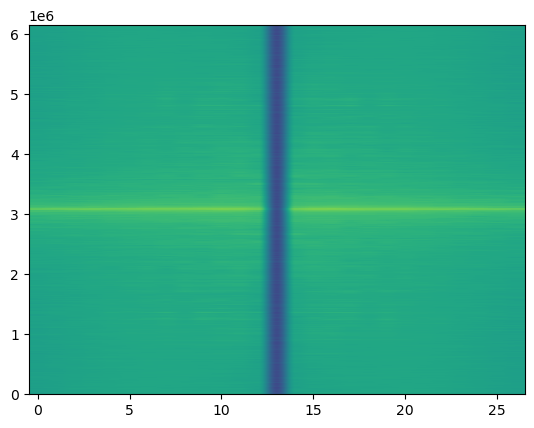

In [6]:
plt.imshow(np.log10(np.abs(ft)), aspect='auto',
             origin='lower')